In [6]:
!nvidia-smi

Fri Mar  8 16:24:03 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    23W / 320W |   1711MiB / 16376MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import wandb

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_loader_new_version0229 import *

from model import *
from pytorch_metric_learning import losses
import torch.optim as optim

In [8]:
mimic_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0308).csv.gz'
eicu_data_dir = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0308).csv.gz'

In [9]:
## Build Dataset 
print(f'Build Dataset ....')

dataset_train = TrainingDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
# loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True, drop_last=True)

y_train_indices = dataset_train.df_num.index
y_train = [dataset_train.y[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
    
samples_weight = np.array([weight[int(t)-1] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

loader_train = DataLoader(dataset_train, batch_size=64, shuffle=False, sampler=sampler, drop_last=True)

dataset_val = TrainingDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
loader_val = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=True)

# y_valid_indices = dataset_val.df_num.index
# y_valid = [dataset_val.y[i] for i in y_valid_indices]
# class_sample_count = np.array([len(np.where(y_valid == t)[0]) for t in np.unique(y_valid)])

# weight = 1. / class_sample_count
    
# samples_weight = np.array([weight[int(t)-1] for t in y_valid])
# samples_weight = torch.from_numpy(samples_weight)
# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# loader_val = DataLoader(dataset_val, batch_size=128, shuffle=False, sampler=sampler, drop_last=True)

# Tuple Containing the number of unique values within each category
card_categories = []
for col in dataset_train.df_cat.columns:
    card_categories.append(dataset_train.df_cat[col].nunique())

Build Dataset ....
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     13766
4.0     17961
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1191
4.0     1383
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.01:0.03:0.04
테스트셋 클래스 비율: 0.95:0.01:0.02:0.02
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 2907
테스트셋 환자 수: 329
학습셋 체류 수: 2961
테스트셋 체류 수: 330
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.38
시도한 시행 횟수: 0
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    473941
2.0      5128
3.0     13766
4.0     17961
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    53103
2.0      512
3.0     1191
4.0     1383
Name: count, dtype: int64
-

In [5]:
# for inference
# eicu_train = TableDataset(data_path=eicu_data_dir, data_type='eicu',mode='valid',seed=9040)
# loader_eicu_out = DataLoader(eicu_train, batch_size=32, shuffle=False, drop_last=False)

# mimic_train = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='train',seed=9040)
# loader_trn_out = DataLoader(mimic_train, batch_size=32, shuffle=False, drop_last=False)

# mimic_valid = TableDataset(data_path=mimic_data_dir, data_type='mimic',mode='valid',seed=9040)
# loader_val_out = DataLoader(mimic_valid, batch_size=32, shuffle=False, drop_last=False)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 7759
seed_everything(seed = SEED)

In [11]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [14]:
import gc
gc.collect()
import optuna
from optuna.trial import TrialState

path_model = "./checkpoint"
if not os.path.exists(path_model):
    os.makedirs(os.path.join(path_model))

def param():
    categories = card_categories
    num_continuous = 158
    dim = 78                       # Embedding Dimension of Input Data  32
    depth = 4                      # Nums of Attention Layer Depth  6
    heads = 5                      # Nums of Attention head
    dim_head = 52                 # Dimension of Attention(Q,K,V)
    attn_dropout = 0.4585             # Ratio of Attention Layer dropout
    ff_dropout = 0.5641  # Ratio of FeedForward Layer dropout
    temp = 0.2533 
    total_epoch = 300
    lr =  0.000007485184106420897
    num_special_tokens = 2
    return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens 


def train(trial, search = False):
    global emb_model, optimizer, train_loss_history  # train_loss_history 추가
    # device            = torch.device('cuda:0')
    train_loss_history = []  # Epoch별 평균 train loss 저장을 위한 리스트 초기화
    patience = 5
    early_stop_counter = 0
    categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens = param()

    
    
    log_file = "FT-Transformer(0309).txt" 
        
    def log_message(message):
        with open(log_file, "a") as file:
            file.write(message + "\n")
        print(message)
    def log_message_not_print(message):
        with open(log_file, "a") as file:
            file.write(message + "\n")
        
    search_iter = 0
    # search parameters
    if search == True:
        
        search_iter += 1
        
        lr = trial.suggest_uniform('lr', 0.000009, 0.0005)
        dim      = trial.suggest_int('emb dim', 60,100)
        dim_head      = trial.suggest_int('Dimension of Attention(Q,K,V)', 16,100)
        heads = trial.suggest_int('head', 2,6)
        depth      = trial.suggest_int('depth', 2,4)
        ff_dropout = trial.suggest_uniform('FeedForward Layer dropout', 0.5, 0.79)
        temp       = trial.suggest_uniform('temp', 0.1, 0.5)
        lambda_weight = trial.suggest_uniform('weight decay', 0.2, 0.9)
        
    log_message(f'learning_rate : {lr}, \nepoch :  {total_epoch}, Embedding Dimension of Input Data : {dim}, Dimension of Attention : {dim_head}, Attention Head : {heads}, Nums of Attention Layer Depth : {depth} drop_rate : {ff_dropout:.4f} temperature : {temp:.4f}')
    wandb.init(name=f'Ftt-training(0309): {lr}',
        project="ECP_CONT", config={
        "learning_rate": lr,
        "dropout": ff_dropout,
        'categories': categories,
        'num_continuous':num_continuous,
        'dim': dim,
        'depth':depth,
        'heads':heads,
        'dim_head':dim_head,
        'attn_dropout':attn_dropout,
        'temp':temp,
        # 'weight decay':lambda_weight,
        'num_special_tokens':num_special_tokens,
        "architecture": "FTT",
        "dataset": "MIMIC-IV",
    })
    # 모델 정의
    emb_model = FTTransformer(categories=categories,
    num_continuous=num_continuous,
    dim=dim,
    depth=depth,
    heads=heads,
    dim_head=dim_head,
    num_special_tokens = 2,
    attn_dropout=attn_dropout,
    ff_dropout=ff_dropout).to(device)
    
    # print(emb_model)

    contrastive_loss = losses.SupConLoss(temperature=temp)
    # optimizer = optim.RMSprop(emb_model.parameters(), lr= lr)
    optimizer = optim.AdamW(emb_model.parameters(), lr = lr)
    # scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=2, eta_max=0.1,  T_up=10, gamma=0.5)
    
    ## Model Train and Eval
    Best_valid_loss = 1e9
    for epoch in range(1, total_epoch+1):
        emb_model.train()
        running_loss = 0

        # current_lr = optimizer.param_groups[0]["lr"]
        
        for num_iter, batch_data in enumerate(tqdm(loader_train)):
            optimizer.zero_grad()
            
            X_num, X_cat, label = batch_data
            X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)

            latent, _ = emb_model(X_cat,X_num,True)
            label =  label.type(torch.LongTensor)
            
            # backward pass
            loss = contrastive_loss(latent, label)
            # loss = criterion(output, label.unsqueeze(dim = 1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # scheduler.step()  
            
        avg_train_loss = running_loss / len(loader_train)
        train_loss_history.append(avg_train_loss)  # 평균 train loss 저장
        log_message_not_print(f'Epoch {epoch}/{total_epoch} - Train Loss: {avg_train_loss:.4f}')
        
        
        with torch.no_grad():
            emb_model.eval()
            running_loss = 0
            for num_iter, batch_data in enumerate(tqdm(loader_val)):
                X_num, X_cat, label = batch_data
                X_num, X_cat, label = X_num.to(device), X_cat.to(device), label.to(device)
                
                latent,_ = emb_model(X_cat,X_num,True)
                loss = contrastive_loss(latent, label)                
                running_loss += loss.item()
                
        avg_valid_loss = np.round(running_loss / len(loader_val),4) 
        log_message_not_print(f'Epoch{epoch} / {total_epoch} Valid Loss : {avg_valid_loss}')
        wandb.log({"train loss":avg_train_loss, "valid loss":avg_valid_loss})

        if avg_valid_loss < Best_valid_loss:
            # log_message(f'Best Loss {Best_valid_loss:.4f} -> {running_loss / len(loader_val):.4f} Update! & Save Checkpoint')
            Best_valid_loss = avg_valid_loss
            early_stop_counter = 0
            torch.save(emb_model.state_dict(),f'{path_model}/FTTransformer_pattern.pth')
            
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            log_message("Early stopping triggered due to valid loss")
            # trial.set_user_attr("early_stopped", True)
            # return TrialState.PRUNED
            return emb_model
        
    # return avg_valid_loss
    return emb_model

In [9]:
# warnings.filterwarnings("ignore")
# import os
# import optuna

# # os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= '0'
# os.environ['CUDA_LAUNCH_BLOCKING']= '1'
# n_gpu             = 1
# device            = torch.device('cuda:0')

# # Set parameters

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
# study.optimize(train, n_trials = 30) 

# pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
# complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

[I 2024-02-12 06:24:15,343] A new study created in memory with name: no-name-a2e010f9-a968-4af1-af5a-828aab7ab829
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


learning_rate : 0.0002280465309612618, 
epoch :  30, Embedding Dimension of Input Data : 62, Dimension of Attention : 67, Attention Head : 2, Nums of Attention Layer Depth : 2 drop_rate : 0.5584 temperature : 0.4799 weight decay : 0.8743


wandb: Currently logged in as: rnjswjddmf. Use `wandb login --relogin` to force relogin


100%|██████████| 876/876 [00:17<00:00, 48.99it/s]
[I 2024-02-12 06:43:04,573] Trial 0 finished with value: 2.0 and parameters: {'lr': 0.0002280465309612618, 'emb dim': 62, 'Dimension of Attention(Q,K,V)': 67, 'head': 2, 'depth': 2, 'FeedForward Layer dropout': 0.5583547531108376, 'temp': 0.4799392116118094, 'weight decay': 0.8743086164479266}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 0.00013026388709019306, 
epoch :  30, Embedding Dimension of Input Data : 89, Dimension of Attention : 76, Attention Head : 6, Nums of Attention Layer Depth : 2 drop_rate : 0.5983 temperature : 0.3637 weight decay : 0.3085


train loss,█▁▁▁▁
valid loss,▁▁█▃█
train loss,3.3687
valid loss,0.4869


100%|██████████| 876/876 [00:19<00:00, 44.47it/s]
[I 2024-02-12 07:58:54,818] Trial 1 finished with value: 2.0 and parameters: {'lr': 0.00013026388709019306, 'emb dim': 89, 'Dimension of Attention(Q,K,V)': 76, 'head': 6, 'depth': 2, 'FeedForward Layer dropout': 0.5982686221692093, 'temp': 0.3636584090108519, 'weight decay': 0.30850699073743293}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 7.721650085647331e-05, 
epoch :  30, Embedding Dimension of Input Data : 99, Dimension of Attention : 17, Attention Head : 5, Nums of Attention Layer Depth : 4 drop_rate : 0.5237 temperature : 0.2742 weight decay : 0.4624


train loss,█▇▆▆▃▃▂▂▂▂▂▁▁▁
valid loss,▄▄▄▂▂▂▁▂▂▁▂▄█▃
train loss,3.23511
valid loss,0.4859


100%|██████████| 876/876 [00:22<00:00, 39.78it/s]
[I 2024-02-12 09:30:36,301] Trial 2 finished with value: 2.0 and parameters: {'lr': 7.721650085647331e-05, 'emb dim': 99, 'Dimension of Attention(Q,K,V)': 17, 'head': 5, 'depth': 4, 'FeedForward Layer dropout': 0.523686394434595, 'temp': 0.2742028290691827, 'weight decay': 0.4624407816685228}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 0.00017321958930626048, 
epoch :  30, Embedding Dimension of Input Data : 98, Dimension of Attention : 79, Attention Head : 4, Nums of Attention Layer Depth : 2 drop_rate : 0.6468 temperature : 0.1016 weight decay : 0.3668


train loss,█▆▅▅▃▂▂▂▂▁▁
valid loss,▇▆█▃▆▆▁▆█▃▂
train loss,3.24524
valid loss,0.4852


100%|██████████| 876/876 [00:19<00:00, 45.51it/s]
[I 2024-02-12 10:30:40,634] Trial 3 finished with value: 2.0 and parameters: {'lr': 0.00017321958930626048, 'emb dim': 98, 'Dimension of Attention(Q,K,V)': 79, 'head': 4, 'depth': 2, 'FeedForward Layer dropout': 0.6468453918745664, 'temp': 0.10162688969162424, 'weight decay': 0.3667765468139009}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 0.00016082565345561134, 
epoch :  30, Embedding Dimension of Input Data : 62, Dimension of Attention : 29, Attention Head : 3, Nums of Attention Layer Depth : 2 drop_rate : 0.6675 temperature : 0.1499 weight decay : 0.5528


train loss,█▅▃▂▂▂▂▁▁▁
valid loss,▃▃▅▅▄▁▅▃█▅
train loss,3.23714
valid loss,0.4865


100%|██████████| 876/876 [00:17<00:00, 50.86it/s]
[I 2024-02-12 11:13:21,213] Trial 4 finished with value: 2.0 and parameters: {'lr': 0.00016082565345561134, 'emb dim': 62, 'Dimension of Attention(Q,K,V)': 29, 'head': 3, 'depth': 2, 'FeedForward Layer dropout': 0.6675219408788318, 'temp': 0.1498778098103793, 'weight decay': 0.5527906696667251}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 0.00035233764198389273, 
epoch :  30, Embedding Dimension of Input Data : 94, Dimension of Attention : 62, Attention Head : 6, Nums of Attention Layer Depth : 3 drop_rate : 0.5566 temperature : 0.3360 weight decay : 0.8881


train loss,█▆▄▂▁▁▁
valid loss,█▅▁▃▆▂█
train loss,3.24924
valid loss,0.4867


100%|██████████| 876/876 [00:28<00:00, 30.65it/s]
[I 2024-02-12 13:07:28,904] Trial 5 finished with value: 2.0 and parameters: {'lr': 0.00035233764198389273, 'emb dim': 94, 'Dimension of Attention(Q,K,V)': 62, 'head': 6, 'depth': 3, 'FeedForward Layer dropout': 0.5565892368363285, 'temp': 0.33601427326310773, 'weight decay': 0.8881082223460597}. Best is trial 0 with value: 2.0.


Early stopping triggered due to valid loss
learning_rate : 0.00011631895162394367, 
epoch :  30, Embedding Dimension of Input Data : 98, Dimension of Attention : 20, Attention Head : 2, Nums of Attention Layer Depth : 4 drop_rate : 0.5348 temperature : 0.2763 weight decay : 0.3481


train loss,█▇▇▇▇▇▇▃▂▂▁▁▁▁▁
valid loss,▄▄▅▅▄▄▃▂█▂▁▃▃▂▄
train loss,3.27449
valid loss,0.4864


  1%|          | 41/7966 [00:02<07:44, 17.06it/s]

In [15]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

learning_rate : 7.485184106420897e-06, 
epoch :  300, Embedding Dimension of Input Data : 78, Dimension of Attention : 52, Attention Head : 5, Nums of Attention Layer Depth : 4 drop_rate : 0.5641 temperature : 0.2533


train loss,█▅▂▂▁▁▁
valid loss,▄▁▅▄▅▄█
train loss,3.26244
valid loss,0.4932


100%|██████████| 877/877 [00:12<00:00, 68.98it/s]

Early stopping triggered due to valid loss


In [16]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net_ftt(0310_best_batch=64).pt")

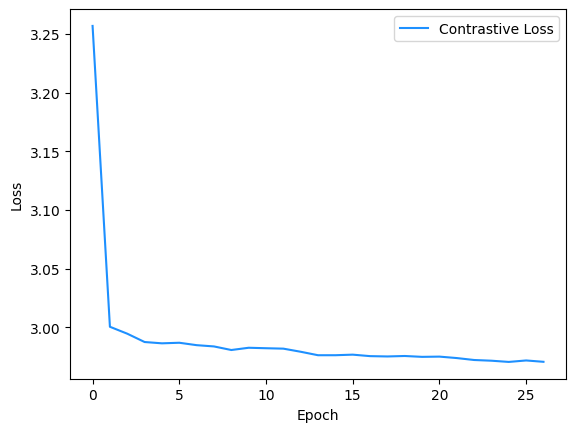

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(27),train_loss_history, color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
device            = torch.device('cuda:0')

In [ ]:
# 모델 정의
model = FTTransformer(categories=card_categories,
num_continuous=157,
dim=78,
depth=4,
heads=5,
dim_head=52,
num_special_tokens = 2,
attn_dropout=0.4585,
ff_dropout=0.5641).to(device)

In [ ]:
# def param():
#     categories = card_categories
#     num_continuous = 157
#     dim = 78                       # Embedding Dimension of Input Data  32
#     depth = 4                      # Nums of Attention Layer Depth  6
#     heads = 5                      # Nums of Attention head
#     dim_head = 52                 # Dimension of Attention(Q,K,V)
#     attn_dropout = 0.4585             # Ratio of Attention Layer dropout
#     ff_dropout = 0.5641  # Ratio of FeedForward Layer dropout
#     temp = 0.2533 
#     total_epoch = 300
#     lr =  0.00007485184106420897
#     num_special_tokens = 2
#     return categories, num_continuous, dim, depth, heads, dim_head, attn_dropout, ff_dropout, temp, total_epoch, lr, num_special_tokens 

In [ ]:
checkpoint = torch.load("Contrastive_Embedding_Net_ftt(0203-45epoch).pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>